# TP 3.1 — RNN & LSTM : prédire un signal par fenêtres glissantes

Objectifs :
- comprendre le passage d'une récurrence simple (RNN) vers un LSTM ;
- implémenter les équations en PyTorch plutôt que d'utiliser `nn.RNN` / `nn.LSTM` ;
- entraîner les deux architectures sur un jeu synthétique many-to-one (prévoir le prochain échantillon d'une sinusoïde bruitée) ;
- réutiliser exactement la même boucle sur les températures quotidiennes de Delhi ;
- analyser les courbes de pertes et les extrapolations pour ajuster `hidden_size`, `lr`, `seq_len`, etc.

💡 Ce notebook est structuré pour guider pas à pas les étudiants : chaque section rappelle la tâche, illustre les fonctions clés (sigmoïde, tanh, fenêtres glissantes) et propose du code modulaire pour expérimenter.


## Plan rapide
1. Rappels sur les fonctions d'activation et visualisations.
2. Génération du jeu synthétique et construction des fenêtres glissantes.
3. Implémentation d'un RNN "à la main" + entraînement/évaluation.
4. Implémentation d'un LSTM "à la main" + entraînement/évaluation.
5. Application sur les températures moyennes réelles (train/val/test).
6. Pistes d'exploration pour aller plus loin.


In [1]:
from pathlib import Path
import copy
import math
import random

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Périphérique utilisé : {device}")


Périphérique utilisé : cuda


## 1. Fonctions d'activation : intuition visuelle

Avant de coder les cellules RNN/LSTM, on fixe les idées sur les non-linéarités utilisées :

- la tangente hyperbolique compacte l'état caché dans $[-1, 1]$ ;
- la sigmoïde des portes LSTM renvoie une "probabilité" d'ouvrir/fermer un flux d'information ;
- l'identité (ou une droite) rappelle l'effet cumulatif des portes oubli/mémoire.

Le graphique suivant commente ces trois fonctions.


/opt/miniconda3​/envs/coursDLgpu/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8712 (\N{ELEMENT OF}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


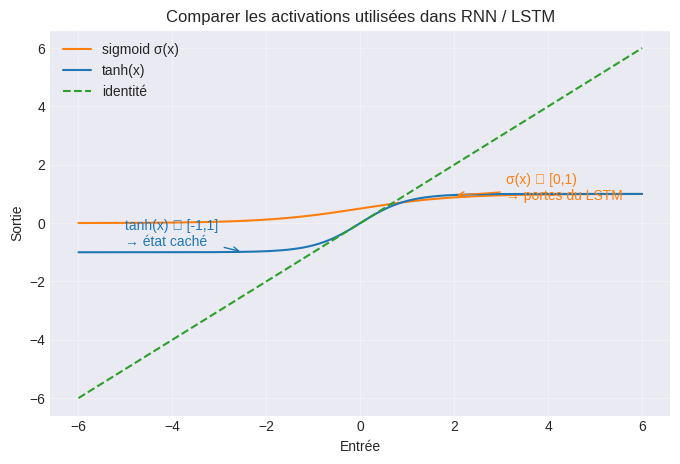

In [2]:
x = np.linspace(-6, 6, 400)
sigmoid = 1 / (1 + np.exp(-x))
tanh = np.tanh(x)
identity = x

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, sigmoid, label='sigmoid σ(x)', color='tab:orange')
ax.plot(x, tanh, label='tanh(x)', color='tab:blue')
ax.plot(x, identity, label='identité', color='tab:green', linestyle='--')
ax.set_title('Comparer les activations utilisées dans RNN / LSTM')
ax.set_xlabel('Entrée')
ax.set_ylabel('Sortie')
ax.legend(loc='best')
ax.grid(alpha=0.3)

ax.annotate('σ(x) ∈ [0,1)\n→ portes du LSTM', xy=(2, sigmoid[300]), xytext=(3.1, 0.8),
            arrowprops=dict(arrowstyle='->', color='tab:orange'), color='tab:orange')
ax.annotate('tanh(x) ∈ [-1,1]\n→ état caché', xy=(-2.5, tanh[100]), xytext=(-5, -0.8),
            arrowprops=dict(arrowstyle='->', color='tab:blue'), color='tab:blue')
plt.show()


## 2. Jeu synthétique : sinusoïdes bruitées et fenêtres glissantes

Nous créons un signal périodique composé de plusieurs sinusoïdes et d'un léger bruit gaussien. L'objectif est de prédire $x_{t+1}$ à partir de la fenêtre $x_{t-H+1}, \dots, x_t$ (problème many-to-one).


In [3]:
rng = np.random.default_rng(SEED)
N_SAMPLES = 6000
TIME = np.arange(N_SAMPLES, dtype=np.float32)

signal = (
    0.6 * np.sin(2 * np.pi * 0.015 * TIME)
    + 0.3 * np.sin(2 * np.pi * 0.04 * TIME + np.pi / 5)
    + 0.1 * np.sin(2 * np.pi * 0.005 * TIME)
    + 0.08 * rng.standard_normal(N_SAMPLES)
).astype(np.float32)

print(f'Signal synthétique : {signal.shape}')


Signal synthétique : (6000,)


### Visualisation globale et découpage train/val/test

On découpe la série temporelle (non mélangée) en 70 % apprentissage, 15 % validation, 15 % test. Le graphique ci-dessous montre les tranches temporelles pour garder en tête la séparation.


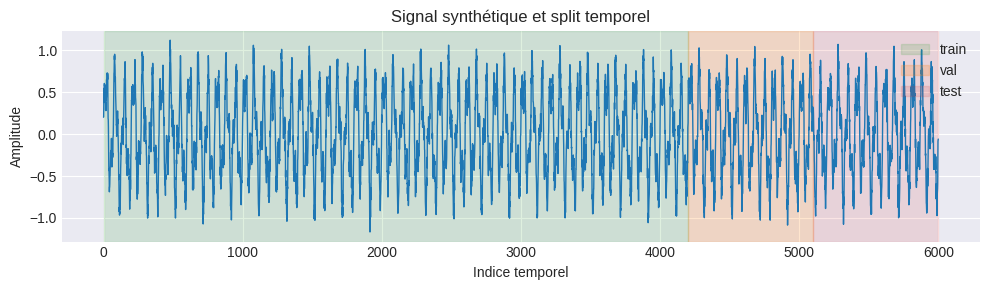

In [4]:
train_ratio, val_ratio = 0.70, 0.15
split_train = int(len(signal) * train_ratio)
split_val = split_train + int(len(signal) * val_ratio)

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(TIME, signal, color='tab:blue', linewidth=1)
ax.axvspan(TIME[0], TIME[split_train], color='tab:green', alpha=0.15, label='train')
ax.axvspan(TIME[split_train], TIME[split_val], color='tab:orange', alpha=0.20, label='val')
ax.axvspan(TIME[split_val], TIME[-1], color='tab:red', alpha=0.12, label='test')
ax.set_title('Signal synthétique et split temporel')
ax.set_xlabel('Indice temporel')
ax.set_ylabel('Amplitude')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


### Construction des fenêtres glissantes

On transforme la série en fenêtres de longueur `seq_len`. Pour chaque fenêtre $X \in \mathbb{R}^{H}$ on prédit le prochain point `y`.

👉 Les fonctions utilitaires ci-dessous seront réutilisées dans la partie données réelles.


In [5]:
def build_windowed_tensors(features: np.ndarray, targets: np.ndarray, seq_len: int):
    """Retourne les tenseurs (X, y) avec fenêtres glissantes.

    features : tableau (T, d_in)
    targets  : tableau (T, d_out)
    seq_len  : taille de la fenêtre
    """
    assert features.shape[0] == targets.shape[0], 'Features et targets doivent avoir la même longueur.'
    if seq_len >= len(features):
        raise ValueError('seq_len doit être strictement inférieur au nombre de points disponibles.')
    X = np.stack([features[i:i + seq_len] for i in range(len(features) - seq_len)], axis=0)
    y = targets[seq_len:]
    return torch.from_numpy(X).float(), torch.from_numpy(y).float()

def time_based_split(X: torch.Tensor, y: torch.Tensor, train_ratio=0.7, val_ratio=0.15):
    total = X.shape[0]
    n_train = int(total * train_ratio)
    n_val = int(total * val_ratio)
    if n_train + n_val >= total:
        raise ValueError("Les ratios laissent trop peu d'exemples pour le test.")
    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train:n_train + n_val], y[n_train:n_train + n_val]
    X_test, y_test = X[n_train + n_val:], y[n_train + n_val:]
    return {
        'train': (X_train, y_train),
        'val'  : (X_val, y_val),
        'test' : (X_test, y_test),
    }

def make_dataloaders(splits: dict, batch_size=64):
    loaders = {}
    for split_name, (X_split, y_split) in splits.items():
        dataset = TensorDataset(X_split, y_split)
        loaders[split_name] = DataLoader(dataset, batch_size=batch_size, shuffle=(split_name == 'train'))
    return loaders


In [6]:
SEQ_LEN_SYNTH = 40
BATCH_SIZE_SYNTH = 128

features_syn = signal[:, None]
targets_syn = features_syn  # on prédit le signal lui-même

X_syn, y_syn = build_windowed_tensors(features_syn, targets_syn, seq_len=SEQ_LEN_SYNTH)
splits_syn = time_based_split(X_syn, y_syn, train_ratio=train_ratio, val_ratio=val_ratio)
loaders_syn = make_dataloaders(splits_syn, batch_size=BATCH_SIZE_SYNTH)

for split, (X_part, y_part) in splits_syn.items():
    print(f"{split:<5} -> X: {tuple(X_part.shape)}, y: {tuple(y_part.shape)}")


train -> X: (4172, 40, 1), y: (4172, 1)
val   -> X: (894, 40, 1), y: (894, 1)
test  -> X: (894, 40, 1), y: (894, 1)


### Illustration d'une fenêtre glissante

La figure suivante montre comment une fenêtre de longueur 40 (bandes bleues) est utilisée pour prédire l'échantillon suivant (croix orange). Visualiser cette mécanique aide à raisonner sur la dépendance temporelle.


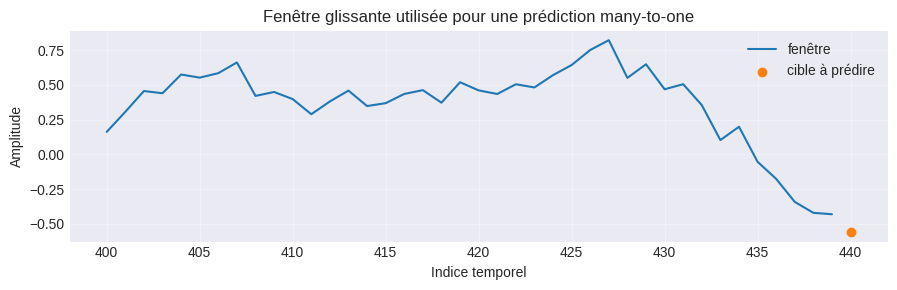

In [7]:
window_index = 400
window = X_syn[window_index].numpy().squeeze()
next_point = y_syn[window_index].item()

fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(np.arange(window_index, window_index + SEQ_LEN_SYNTH), window, label='fenêtre', color='tab:blue')
ax.scatter(window_index + SEQ_LEN_SYNTH, next_point, color='tab:orange', label='cible à prédire')
ax.set_title('Fenêtre glissante utilisée pour une prédiction many-to-one')
ax.set_xlabel('Indice temporel')
ax.set_ylabel('Amplitude')
ax.legend(loc='best')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 3. Implémenter un RNN "à la main"

Nous codons maintenant le RNN tel que vu au cours :

$$
\begin{aligned}
 h_t &= \tanh(W_{xh} x_t + W_{hh} h_{t-1} + b_h) \\ 
 \hat{y}_t &= W_{hy} h_t + b_y
\end{aligned}
$$

Le but est d'entraîner le modèle many-to-one : on ne garde que $h_T$ (dernier pas) pour la régression.


In [8]:
class ManualRNNRegressor(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.input_linear = nn.Linear(input_dim, hidden_dim)
        self.hidden_linear = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.readout = nn.Linear(hidden_dim, output_dim)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.input_linear.weight)
        nn.init.zeros_(self.input_linear.bias)
        nn.init.orthogonal_(self.hidden_linear.weight)
        nn.init.xavier_uniform_(self.readout.weight)
        nn.init.zeros_(self.readout.bias)

    def forward(self, x: torch.Tensor, return_sequences: bool = False):
        batch_size, seq_len, _ = x.shape
        h_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)
        states = []
        for t in range(seq_len):
            h_t = torch.tanh(self.input_linear(x[:, t, :]) + self.hidden_linear(h_t))
            if return_sequences:
                states.append(h_t)
        output = self.readout(h_t)
        if return_sequences:
            return output, torch.stack(states, dim=1)
        return output


### Boucles d'entraînement / évaluation communes

Nous regroupons ici les fonctions utilitaires :
- `run_epoch` pour une passe train ou val,
- `train_model` pour plusieurs époques avec sauvegarde du meilleur modèle (val),
- `evaluate_loader` pour calculer une métrique,
- `plot_history` pour visualiser `loss_train` et `loss_val`.


In [9]:
def run_epoch(model, loader, criterion, optimizer=None, clip_value=1.5):
    train_mode = optimizer is not None
    if train_mode:
        model.train()
    else:
        model.eval()
    epoch_loss = 0.0
    count = 0
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        with torch.set_grad_enabled(train_mode):
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
        if train_mode:
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)
            optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
        count += X_batch.size(0)
    return epoch_loss / count

def train_model(model, loaders, criterion, optimizer, epochs=50, patience=10):
    history = {'train': [], 'val': []}
    best_val = float('inf')
    best_state = copy.deepcopy(model.state_dict())
    wait = 0
    for epoch in range(1, epochs + 1):
        train_loss = run_epoch(model, loaders['train'], criterion, optimizer)
        val_loss = run_epoch(model, loaders['val'], criterion)
        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())
            wait = 0
        else:
            wait += 1

        if epoch % max(1, epochs // 10) == 0 or epoch == 1:
            print(f"Epoch {epoch:03d} | train {train_loss:.5f} | val {val_loss:.5f}")
        if wait >= patience:
            print(f"⏹️  Early stopping (patience={patience}) à l'époque {epoch}.")
            break
    model.load_state_dict(best_state)
    return history, best_val

def evaluate_loader(model, loader, criterion):
    return run_epoch(model, loader, criterion)

def plot_history(history, title='Courbes de perte'):
    epochs = range(1, len(history['train']) + 1)
    plt.figure(figsize=(6, 3))
    plt.plot(epochs, history['train'], label='train', color='tab:blue')
    plt.plot(epochs, history['val'], label='val', color='tab:orange')
    plt.xlabel('Époque')
    plt.ylabel('MSE')
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


### Entraînement du RNN sur les données synthétiques

Modifiez librement `hidden_dim`, `lr`, `epochs`, `seq_len` pour observer l'impact sur la convergence.


Epoch 001 | train 0.03223 | val 0.01567
Epoch 008 | train 0.00915 | val 0.00956
Epoch 016 | train 0.00863 | val 0.00893
Epoch 024 | train 0.00839 | val 0.00891
Epoch 032 | train 0.00827 | val 0.00862
Epoch 040 | train 0.00817 | val 0.00843
Epoch 048 | train 0.00802 | val 0.00884
⏹️  Early stopping (patience=12) à l'époque 54.
Meilleur val loss RNN : 0.008260


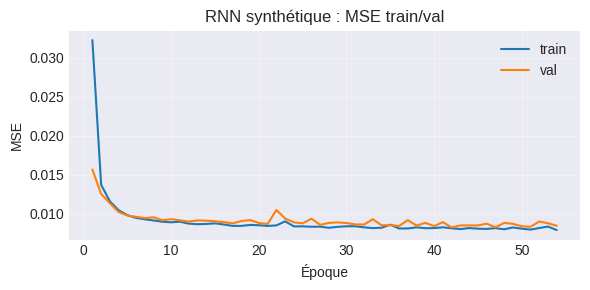

In [10]:
HIDDEN_RNN = 32
LR_RNN = 1e-3
EPOCHS_RNN = 80
PATIENCE_RNN = 12

rnn_model = ManualRNNRegressor(input_dim=features_syn.shape[1], hidden_dim=HIDDEN_RNN, output_dim=targets_syn.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=LR_RNN)

history_rnn, best_val_rnn = train_model(
    rnn_model, loaders_syn, criterion, optimizer, epochs=EPOCHS_RNN, patience=PATIENCE_RNN
)
print(f"Meilleur val loss RNN : {best_val_rnn:.6f}")
plot_history(history_rnn, title='RNN synthétique : MSE train/val')


### Analyse qualitative des prédictions (jeu synthétique)

1. **Erreur test** : MSE sur fenêtres tenues à l'écart.
2. **Prédictions vs vérité** : on passe toutes les fenêtres de test pour vérifier la qualité moyenne.
3. **Déroulé libre** : à partir d'une fenêtre du test, on prédit 120 pas au-delà en réinjectant la prédiction comme prochaine entrée.


MSE test (RNN synthétique) : 0.008590


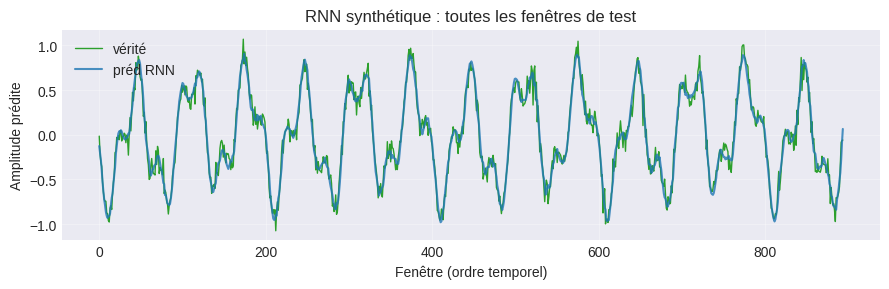

In [11]:
@torch.no_grad()
def get_predictions(model, loader):
    model.eval()
    preds = []
    targets = []
    for X_batch, y_batch in loader:
        preds.append(model(X_batch.to(device)).cpu())
        targets.append(y_batch)
    return torch.cat(preds), torch.cat(targets)

@torch.no_grad()
def rollout_autoregressive(model, initial_window, future_features, target_truth=None, target_col=0):
    model.eval()
    window = initial_window.unsqueeze(0).to(device)
    future_features = future_features.to(device)
    if future_features.dim() == 3:
        future_rows = future_features[:, -1, :]
    elif future_features.dim() == 2:
        future_rows = future_features
    else:
        raise ValueError('future_features doit être (horizon, d_in) ou (horizon, seq_len, d_in).')
    preds = []
    for step in range(future_rows.shape[0]):
        pred_step = model(window)
        pred_value = pred_step.squeeze(0)
        preds.append(pred_value.cpu())
        new_row = future_rows[step].clone()
        new_row[target_col] = pred_value
        window = torch.cat([window[:, 1:, :], new_row.unsqueeze(0).unsqueeze(0)], dim=1)
    preds = torch.stack(preds)
    if target_truth is not None:
        return preds, target_truth
    return preds

criterion_test = nn.MSELoss()
test_loss_rnn = evaluate_loader(rnn_model, loaders_syn['test'], criterion_test)
print(f'MSE test (RNN synthétique) : {test_loss_rnn:.6f}')

preds_test_rnn, targets_test = get_predictions(rnn_model, loaders_syn['test'])
fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(targets_test.numpy(), label='vérité', color='tab:green', linewidth=1)
ax.plot(preds_test_rnn.numpy(), label='préd RNN', color='tab:blue', alpha=0.8)
ax.set_title('RNN synthétique : toutes les fenêtres de test')
ax.set_xlabel('Fenêtre (ordre temporel)')
ax.set_ylabel('Amplitude prédite')
ax.legend(loc='best')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


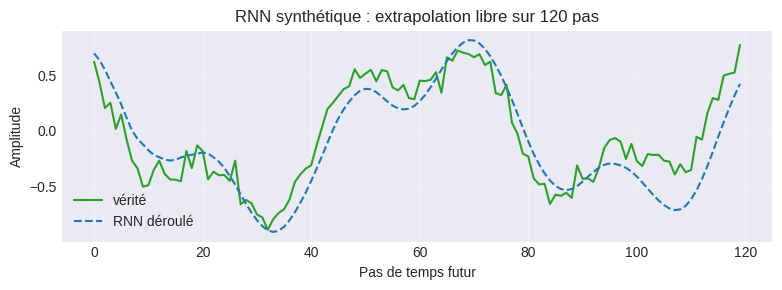

In [12]:

test_start = 50
horizon = 120
initial_window = splits_syn['test'][0][test_start].cpu()
future_feats = splits_syn['test'][0][test_start + 1:test_start + 1 + horizon].cpu()
truth_future = splits_syn['test'][1][test_start + 1:test_start + 1 + horizon].cpu()

roll_preds_rnn, truth_future = rollout_autoregressive(
    rnn_model, initial_window, future_feats, target_truth=truth_future, target_col=0
)

steps = np.arange(horizon)
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(steps, truth_future.numpy().squeeze(), label='vérité', color='tab:green')
ax.plot(steps, roll_preds_rnn.numpy().squeeze(), label='RNN déroulé', color='tab:blue', linestyle='--')
ax.set_title('RNN synthétique : extrapolation libre sur 120 pas')
ax.set_xlabel('Pas de temps futur')
ax.set_ylabel('Amplitude')
ax.legend(loc='best')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 4. Implémenter un LSTM "à la main"

Le LSTM ajoute des portes pour mieux contrôler le flux d'information. Les équations implémentées :

$$
\begin{aligned}
\begin{bmatrix}
 f_t \\ 
 i_t \\ 
 \tilde{c}_t \\ 
 o_t
\end{bmatrix}
&=
\begin{bmatrix}
 \sigma \\ 
 \sigma \\ 
 \tanh \\ 
 \sigma
\end{bmatrix}
\left(W
\begin{bmatrix}
 x_t \\ 
 h_{t-1}
\end{bmatrix} + b\right),\\
 c_t &= f_t \odot c_{t-1} + i_t \odot \tilde{c}_t,\\
 h_t &= o_t \odot \tanh(c_t),\\
 \hat{y}_t &= W_{hy} h_t + b_y.
\end{aligned}
$$

On code ces opérations sans utiliser `nn.LSTM` pour bien visualiser les portes.


In [13]:
class ManualLSTMRegressor(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.gates = nn.Linear(input_dim + hidden_dim, 4 * hidden_dim)
        self.readout = nn.Linear(hidden_dim, output_dim)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.gates.weight)
        nn.init.zeros_(self.gates.bias)
        nn.init.xavier_uniform_(self.readout.weight)
        nn.init.zeros_(self.readout.bias)

    def forward(self, x: torch.Tensor, return_sequences: bool = False):
        batch_size, seq_len, _ = x.shape
        h_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)
        states = []
        cells = []
        for t in range(seq_len):
            combined = torch.cat([x[:, t, :], h_t], dim=1)
            gates = self.gates(combined)
            f_t, i_t, g_t, o_t = gates.chunk(4, dim=1)
            f_t = torch.sigmoid(f_t)
            i_t = torch.sigmoid(i_t)
            g_t = torch.tanh(g_t)
            o_t = torch.sigmoid(o_t)
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            if return_sequences:
                states.append(h_t)
                cells.append(c_t)
        output = self.readout(h_t)
        if return_sequences:
            return output, torch.stack(states, dim=1), torch.stack(cells, dim=1)
        return output


### Entraînement du LSTM sur les données synthétiques

Même pipeline que pour le RNN, seules les dimensions cachées et le modèle changent.


Epoch 001 | train 0.14757 | val 0.08848
Epoch 008 | train 0.01245 | val 0.01204
Epoch 016 | train 0.01014 | val 0.01038
Epoch 024 | train 0.01019 | val 0.01016
Epoch 032 | train 0.00977 | val 0.00974
Epoch 040 | train 0.00918 | val 0.00999
Epoch 048 | train 0.00886 | val 0.01002
Epoch 056 | train 0.00878 | val 0.00967
Epoch 064 | train 0.00867 | val 0.00870
Epoch 072 | train 0.00848 | val 0.00845
Epoch 080 | train 0.00794 | val 0.00816
Meilleur val loss LSTM : 0.008159


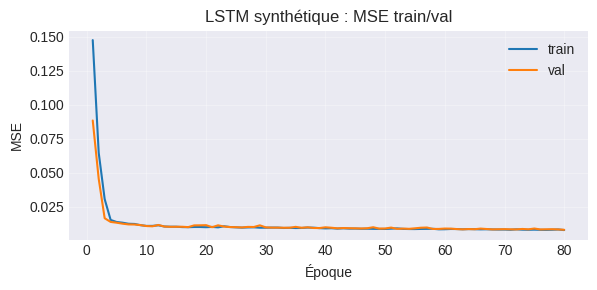

In [14]:
HIDDEN_LSTM = 32
LR_LSTM = 1e-3
EPOCHS_LSTM = 80
PATIENCE_LSTM = 12

lstm_model = ManualLSTMRegressor(input_dim=features_syn.shape[1], hidden_dim=HIDDEN_LSTM, output_dim=targets_syn.shape[1]).to(device)
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=LR_LSTM)

history_lstm, best_val_lstm = train_model(
    lstm_model, loaders_syn, criterion, optimizer_lstm, epochs=EPOCHS_LSTM, patience=PATIENCE_LSTM
)
print(f"Meilleur val loss LSTM : {best_val_lstm:.6f}")
plot_history(history_lstm, title='LSTM synthétique : MSE train/val')


### Évaluation qualitative (jeu synthétique)

On reproduit l'analyse précédente pour comparer la capacité d'extrapolation du LSTM.


MSE test (LSTM synthétique) : 0.008290


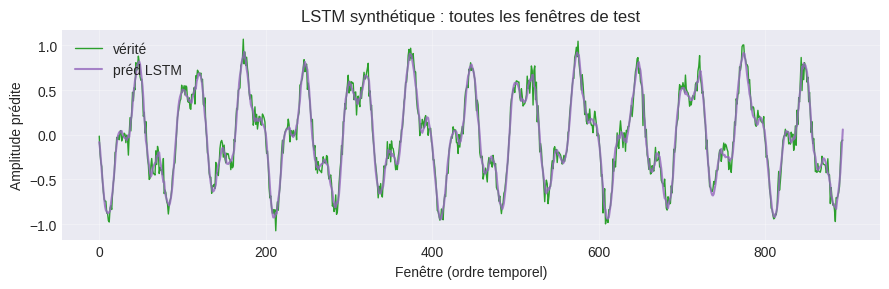

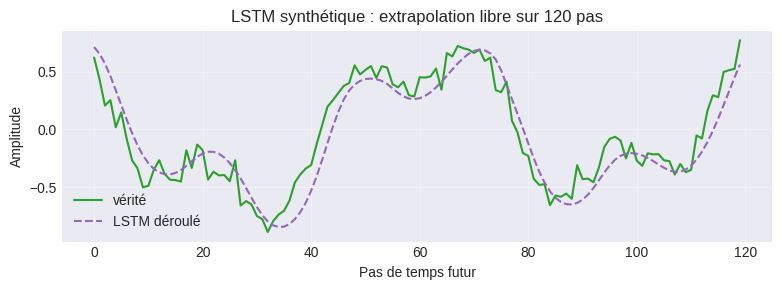

In [15]:
test_loss_lstm = evaluate_loader(lstm_model, loaders_syn['test'], criterion_test)
print(f'MSE test (LSTM synthétique) : {test_loss_lstm:.6f}')

preds_test_lstm, _ = get_predictions(lstm_model, loaders_syn['test'])
fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(targets_test.numpy(), label='vérité', color='tab:green', linewidth=1)
ax.plot(preds_test_lstm.numpy(), label='préd LSTM', color='tab:purple', alpha=0.8)
ax.set_title('LSTM synthétique : toutes les fenêtres de test')
ax.set_xlabel('Fenêtre (ordre temporel)')
ax.set_ylabel('Amplitude prédite')
ax.legend(loc='best')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

roll_preds_lstm, _ = rollout_autoregressive(
    lstm_model, initial_window, future_feats, target_truth=truth_future, target_col=0
)

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(steps, truth_future.numpy().squeeze(), label='vérité', color='tab:green')
ax.plot(steps, roll_preds_lstm.numpy().squeeze(), label='LSTM déroulé', color='tab:purple', linestyle='--')
ax.set_title('LSTM synthétique : extrapolation libre sur 120 pas')
ax.set_xlabel('Pas de temps futur')
ax.set_ylabel('Amplitude')
ax.legend(loc='best')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Comparaison rapide

- **MSE** : le LSTM doit mieux conserver les régularités lorsqu'une porte d'oubli < 1.
- **Déroulé libre** : vérifier si le RNN diverge plus vite que le LSTM.
- **Explorations possibles** : augmenter `seq_len`, modifier la variance du bruit, jouer sur `hidden_dim`.


## 5. Données réelles : températures quotidiennes

On reprend les données `DailyDelhiClimateTrain/Test.csv` (même prétraitement que dans _TP_3.1_temperature_old_). 
La différence :
- on normalise la température (`StandardScaler`),
- on encode la saisonnalité via les transformations sin/cos du jour de l'année,
- on applique exactement la même boucle many-to-one que pour les sinusoïdes.


In [16]:
data_root = Path('data')
train_path = data_root / 'DailyDelhiClimateTrain.csv'
test_path = data_root / 'DailyDelhiClimateTest.csv'
assert train_path.exists() and test_path.exists(), 'Fichiers de température manquants.'

df_train = (pd.read_csv(train_path, parse_dates=['date'])
              .set_index('date')
              .sort_index())

df_test = (pd.read_csv(test_path, parse_dates=['date'])
             .set_index('date')
             .sort_index())

print(df_train.head(3))
print(df_test.head(3))


             meantemp  humidity  wind_speed  meanpressure
date                                                     
2013-01-01  10.000000      84.5    0.000000   1015.666667
2013-01-02   7.400000      92.0    2.980000   1017.800000
2013-01-03   7.166667      87.0    4.633333   1018.666667
             meantemp   humidity  wind_speed  meanpressure
date                                                      
2017-01-01  15.913043  85.869565    2.743478     59.000000
2017-01-02  18.500000  77.222222    2.894444   1018.277778
2017-01-03  17.111111  81.888889    4.016667   1018.333333


### Prétraitement : interpolation et features saisonniers

- interpolation temporelle pour combler les rares valeurs manquantes ;
- transformation du jour $d$ en deux composantes sin/cos périodiques ;
- normalisation `z-score` sur la température d'entraînement (appliquée ensuite au test).


In [17]:
def add_seasonal_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    day = out.index.dayofyear.to_numpy(dtype=np.float32)
    out['day_sin'] = np.sin(2 * np.pi * day / 365.0)
    out['day_cos'] = np.cos(2 * np.pi * day / 365.0)
    return out

train_proc = add_seasonal_features(df_train).interpolate(method='time')
test_proc = add_seasonal_features(df_test).interpolate(method='time')

temp_scaler = StandardScaler()
train_temp_norm = temp_scaler.fit_transform(train_proc[['meantemp']]).astype(np.float32)
test_temp_norm = temp_scaler.transform(test_proc[['meantemp']]).astype(np.float32)

train_features = np.concatenate(
    [train_temp_norm, train_proc[['day_sin', 'day_cos']].to_numpy(dtype=np.float32)], axis=1
)
train_targets = train_temp_norm.astype(np.float32)

test_features = np.concatenate(
    [test_temp_norm, test_proc[['day_sin', 'day_cos']].to_numpy(dtype=np.float32)], axis=1
)
test_targets = test_temp_norm.astype(np.float32)

print('train_features:', train_features.shape)
print('test_features :', test_features.shape)


train_features: (1462, 3)
test_features : (114, 3)


### Visualiser la série réelle

La figure met en regard la température normalisée et les composantes sin/cos qui renseignent le modèle sur la saison.


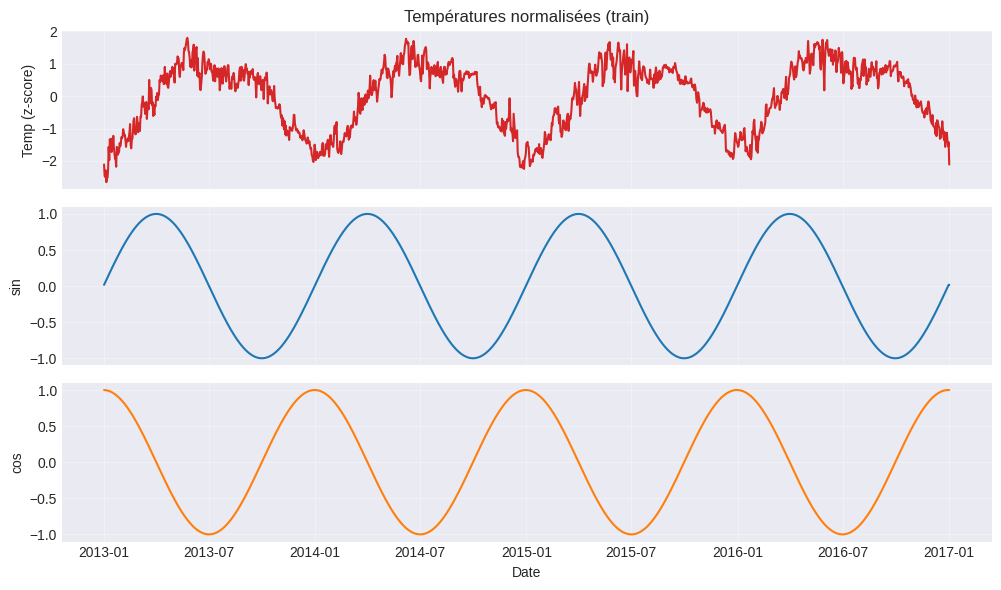

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
axes[0].plot(train_proc.index, train_temp_norm.squeeze(), color='tab:red')
axes[0].set_ylabel('Temp (z-score)')
axes[0].set_title('Températures normalisées (train)')
axes[1].plot(train_proc.index, train_proc['day_sin'], color='tab:blue')
axes[1].set_ylabel('sin')
axes[2].plot(train_proc.index, train_proc['day_cos'], color='tab:orange')
axes[2].set_ylabel('cos')
axes[2].set_xlabel('Date')
for ax in axes:
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Fenêtres glissantes et splits

On conserve la même taille de fenêtre (`seq_len=60` par défaut). Split 80 % train / 20 % val sur l'ensemble d'apprentissage (ordre temporel). Le test reste séparé.


In [19]:
SEQ_LEN_REAL = 60
BATCH_SIZE_REAL = 128
train_ratio_real = 0.80
val_ratio_real = 0.20

X_real_full, y_real_full = build_windowed_tensors(train_features, train_targets, seq_len=SEQ_LEN_REAL)
splits_real = time_based_split(X_real_full, y_real_full, train_ratio=train_ratio_real, val_ratio=val_ratio_real)
loaders_real = make_dataloaders(splits_real, batch_size=BATCH_SIZE_REAL)

X_real_test, y_real_test = build_windowed_tensors(test_features, test_targets, seq_len=SEQ_LEN_REAL)
test_loader_real = DataLoader(TensorDataset(X_real_test, y_real_test), batch_size=BATCH_SIZE_REAL, shuffle=False)

for split, (X_part, y_part) in splits_real.items():
    print(f"{split:<5} -> X: {tuple(X_part.shape)}, y: {tuple(y_part.shape)}")
print(f"test -> X: {tuple(X_real_test.shape)}, y: {tuple(y_real_test.shape)}")


train -> X: (1121, 60, 3), y: (1121, 1)
val   -> X: (280, 60, 3), y: (280, 1)
test  -> X: (1, 60, 3), y: (1, 1)
test -> X: (54, 60, 3), y: (54, 1)


## 5.1 RNN sur températures

On réutilise `ManualRNNRegressor` et les fonctions d'entraînement.


Epoch 001 | train 0.29118 | val 0.09211
Epoch 012 | train 0.04348 | val 0.04668
⏹️  Early stopping (patience=15) à l'époque 21.
Meilleur val loss RNN (températures) : 0.046025


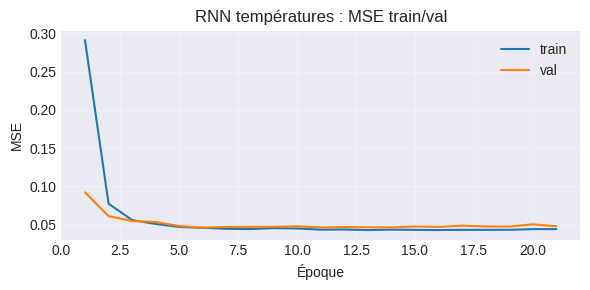

In [20]:
HIDDEN_RNN_REAL = 48
LR_RNN_REAL = 2e-3
EPOCHS_RNN_REAL = 120
PATIENCE_RNN_REAL = 15

rnn_real = ManualRNNRegressor(input_dim=train_features.shape[1], hidden_dim=HIDDEN_RNN_REAL, output_dim=1).to(device)
optimizer_rnn_real = torch.optim.Adam(rnn_real.parameters(), lr=LR_RNN_REAL)

history_rnn_real, best_val_rnn_real = train_model(
    rnn_real, loaders_real, criterion, optimizer_rnn_real, epochs=EPOCHS_RNN_REAL, patience=PATIENCE_RNN_REAL
)
print(f"Meilleur val loss RNN (températures) : {best_val_rnn_real:.6f}")
plot_history(history_rnn_real, title='RNN températures : MSE train/val')


### Évaluation sur test (températures)

On calcule la MSE sur le jeu de test, puis on visualise les prédictions (normalisées et en degrés Celsius).


MSE test RNN (températures normalisées) : 0.048060


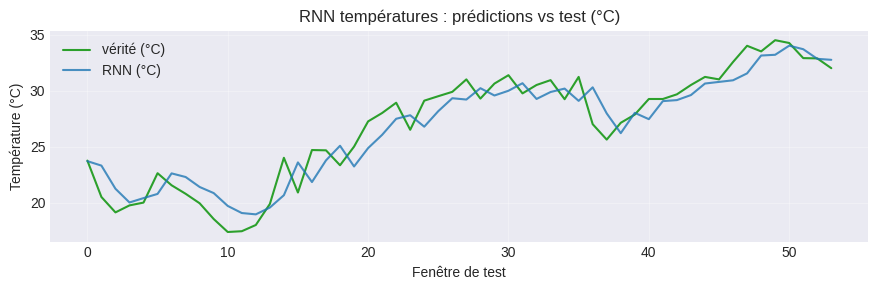

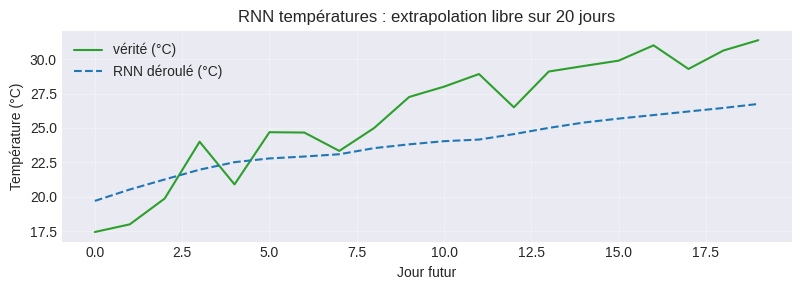

In [21]:
test_loss_rnn_real = evaluate_loader(rnn_real, test_loader_real, criterion_test)
print(f'MSE test RNN (températures normalisées) : {test_loss_rnn_real:.6f}')

preds_test_real_rnn, targets_test_real = get_predictions(rnn_real, test_loader_real)
preds_temp_c = temp_scaler.inverse_transform(preds_test_real_rnn.numpy())
truth_temp_c = temp_scaler.inverse_transform(targets_test_real.numpy())

fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(truth_temp_c, label='vérité (°C)', color='tab:green')
ax.plot(preds_temp_c, label='RNN (°C)', color='tab:blue', alpha=0.8)
ax.set_title('RNN températures : prédictions vs test (°C)')
ax.set_xlabel('Fenêtre de test')
ax.set_ylabel('Température (°C)')
ax.legend(loc='best')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

test_start_real = 10
horizon_real = 20
initial_window_real = X_real_test[test_start_real].cpu()
future_feats_real = X_real_test[test_start_real + 1:test_start_real + 1 + horizon_real].cpu()
truth_future_real = y_real_test[test_start_real + 1:test_start_real + 1 + horizon_real].cpu()

roll_preds_real_rnn, truth_future_real = rollout_autoregressive(
    rnn_real, initial_window_real, future_feats_real, target_truth=truth_future_real, target_col=0
)

roll_preds_real_c = temp_scaler.inverse_transform(roll_preds_real_rnn.numpy())
truth_future_real_c = temp_scaler.inverse_transform(truth_future_real.numpy())

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(range(horizon_real), truth_future_real_c.squeeze(), label='vérité (°C)', color='tab:green')
ax.plot(range(horizon_real), roll_preds_real_c.squeeze(), label='RNN déroulé (°C)', color='tab:blue', linestyle='--')
ax.set_title('RNN températures : extrapolation libre sur 20 jours')
ax.set_xlabel('Jour futur')
ax.set_ylabel('Température (°C)')
ax.legend(loc='best')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 5.2 LSTM sur températures

Même démarche, en conservant la mémoire longue durée.


Epoch 001 | train 0.62658 | val 0.42385
Epoch 012 | train 0.06009 | val 0.06545
Epoch 024 | train 0.05283 | val 0.05901
Epoch 036 | train 0.04694 | val 0.05122
Epoch 048 | train 0.04555 | val 0.04834
Epoch 060 | train 0.04361 | val 0.04576
Epoch 072 | train 0.04450 | val 0.04329
Epoch 084 | train 0.04260 | val 0.04625
⏹️  Early stopping (patience=15) à l'époque 84.
Meilleur val loss LSTM (températures) : 0.042108


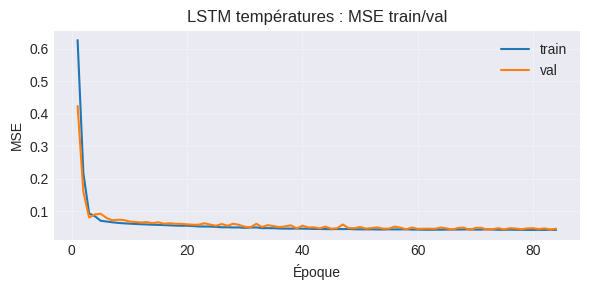

In [22]:
HIDDEN_LSTM_REAL = 48
LR_LSTM_REAL = 2e-3
EPOCHS_LSTM_REAL = 120
PATIENCE_LSTM_REAL = 15

lstm_real = ManualLSTMRegressor(input_dim=train_features.shape[1], hidden_dim=HIDDEN_LSTM_REAL, output_dim=1).to(device)
optimizer_lstm_real = torch.optim.Adam(lstm_real.parameters(), lr=LR_LSTM_REAL)

history_lstm_real, best_val_lstm_real = train_model(
    lstm_real, loaders_real, criterion, optimizer_lstm_real, epochs=EPOCHS_LSTM_REAL, patience=PATIENCE_LSTM_REAL
)
print(f"Meilleur val loss LSTM (températures) : {best_val_lstm_real:.6f}")
plot_history(history_lstm_real, title='LSTM températures : MSE train/val')


### Évaluation sur test (températures)

On compare la dynamique du LSTM à celle du RNN précédent.


MSE test LSTM (températures normalisées) : 0.049245


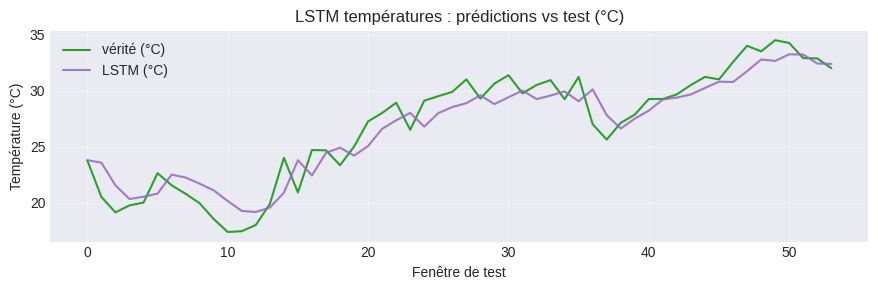

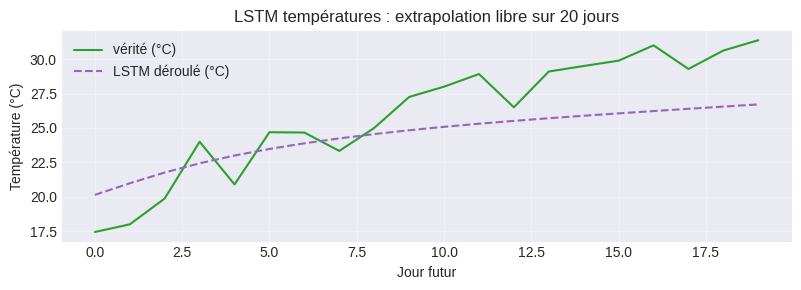

In [23]:
test_loss_lstm_real = evaluate_loader(lstm_real, test_loader_real, criterion_test)
print(f'MSE test LSTM (températures normalisées) : {test_loss_lstm_real:.6f}')

preds_test_real_lstm, _ = get_predictions(lstm_real, test_loader_real)
preds_temp_c_lstm = temp_scaler.inverse_transform(preds_test_real_lstm.numpy())

fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(truth_temp_c, label='vérité (°C)', color='tab:green')
ax.plot(preds_temp_c_lstm, label='LSTM (°C)', color='tab:purple', alpha=0.85)
ax.set_title('LSTM températures : prédictions vs test (°C)')
ax.set_xlabel('Fenêtre de test')
ax.set_ylabel('Température (°C)')
ax.legend(loc='best')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

roll_preds_real_lstm, _ = rollout_autoregressive(
    lstm_real, initial_window_real, future_feats_real, target_truth=truth_future_real, target_col=0
)
roll_preds_real_lstm_c = temp_scaler.inverse_transform(roll_preds_real_lstm.numpy())

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(range(horizon_real), truth_future_real_c.squeeze(), label='vérité (°C)', color='tab:green')
ax.plot(range(horizon_real), roll_preds_real_lstm_c.squeeze(), label='LSTM déroulé (°C)', color='tab:purple', linestyle='--')
ax.set_title('LSTM températures : extrapolation libre sur 20 jours')
ax.set_xlabel('Jour futur')
ax.set_ylabel('Température (°C)')
ax.legend(loc='best')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 6. Pistes d'exploration

- Modifier `hidden_dim`, `seq_len`, `lr` et observer la stabilité des courbes train/val (éviter la divergence).
- Ajouter du bruit ou des ruptures sur le signal synthétique pour tester la robustesse.
- Remplacer la MSE par la MAE, ou ajouter une régularisation L2 dans l'optimiseur (`weight_decay`).
- Implémenter une version bidirectionnelle (en concaténant deux passes) ou empiler plusieurs couches.
- Comparer avec `nn.RNN` / `nn.LSTM` natifs pour vérifier que les équations concordent.


## 7. Étude d'ablation : rôle de l'encodage saisonnier

Nous évaluons l'impact des deux variables sinus/cosinus qui encodent le jour dans l'année.

Démarche :
- on conserve les modèles entraînés plus haut avec les features `[temp_norm, day_sin, day_cos]`;
- on réentraîne un RNN et un LSTM strictement identiques mais alimentés uniquement par la température normalisée ;
- on compare les pertes validation/test et les courbes d'apprentissage.


In [24]:
# Fenêtres sans encodage saisonnier (température uniquement)
train_features_no_pos = train_temp_norm.astype(np.float32)
test_features_no_pos = test_temp_norm.astype(np.float32)

X_real_full_no_pos, y_real_full_no_pos = build_windowed_tensors(
    train_features_no_pos, train_targets, seq_len=SEQ_LEN_REAL
)
splits_real_no_pos = time_based_split(
    X_real_full_no_pos, y_real_full_no_pos,
    train_ratio=train_ratio_real, val_ratio=val_ratio_real
)
loaders_real_no_pos = make_dataloaders(splits_real_no_pos, batch_size=BATCH_SIZE_REAL)

X_real_test_no_pos, y_real_test_no_pos = build_windowed_tensors(
    test_features_no_pos, test_targets, seq_len=SEQ_LEN_REAL
)
test_loader_real_no_pos = DataLoader(
    TensorDataset(X_real_test_no_pos, y_real_test_no_pos),
    batch_size=BATCH_SIZE_REAL, shuffle=False
)

for split, (X_part, y_part) in splits_real_no_pos.items():
    print(f"{split:<5} -> X: {tuple(X_part.shape)}, y: {tuple(y_part.shape)}")
print(f"test -> X: {tuple(X_real_test_no_pos.shape)}, y: {tuple(y_real_test_no_pos.shape)}")


train -> X: (1121, 60, 1), y: (1121, 1)
val   -> X: (280, 60, 1), y: (280, 1)
test  -> X: (1, 60, 1), y: (1, 1)
test -> X: (54, 60, 1), y: (54, 1)


Epoch 001 | train 0.29725 | val 0.10626
Epoch 012 | train 0.04549 | val 0.04661
Epoch 024 | train 0.04201 | val 0.05044
⏹️  Early stopping (patience=15) à l'époque 26.


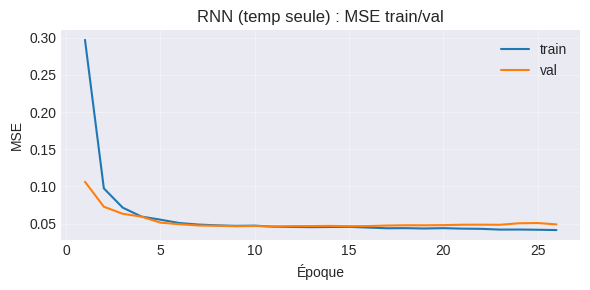

Epoch 001 | train 0.84041 | val 0.60401
Epoch 012 | train 0.06629 | val 0.06342
Epoch 024 | train 0.05963 | val 0.05754
Epoch 036 | train 0.05261 | val 0.05190
Epoch 048 | train 0.04763 | val 0.04583
Epoch 060 | train 0.04742 | val 0.04670
Epoch 072 | train 0.04620 | val 0.04418
⏹️  Early stopping (patience=15) à l'époque 82.


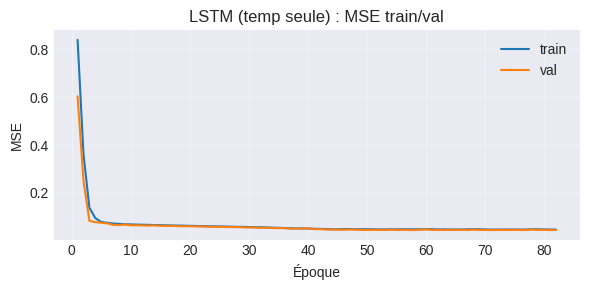

In [25]:
abl_results = [
    {
        'features': 'Temp + sin/cos',
        'model': 'RNN',
        'val_mse': best_val_rnn_real,
        'test_mse': test_loss_rnn_real
    },
    {
        'features': 'Temp + sin/cos',
        'model': 'LSTM',
        'val_mse': best_val_lstm_real,
        'test_mse': test_loss_lstm_real
    },
]

# RNN sans encodage saisonnier
rnn_real_no_pos = ManualRNNRegressor(input_dim=1, hidden_dim=HIDDEN_RNN_REAL, output_dim=1).to(device)
optimizer_rnn_no_pos = torch.optim.Adam(rnn_real_no_pos.parameters(), lr=LR_RNN_REAL)
history_rnn_no_pos, best_val_rnn_no_pos = train_model(
    rnn_real_no_pos, loaders_real_no_pos, criterion, optimizer_rnn_no_pos,
    epochs=EPOCHS_RNN_REAL, patience=PATIENCE_RNN_REAL
)
test_loss_rnn_no_pos = evaluate_loader(rnn_real_no_pos, test_loader_real_no_pos, criterion_test)
abl_results.append({
    'features': 'Temp seule',
    'model': 'RNN',
    'val_mse': best_val_rnn_no_pos,
    'test_mse': test_loss_rnn_no_pos
})
plot_history(history_rnn_no_pos, title='RNN (temp seule) : MSE train/val')

# LSTM sans encodage saisonnier
lstm_real_no_pos = ManualLSTMRegressor(input_dim=1, hidden_dim=HIDDEN_LSTM_REAL, output_dim=1).to(device)
optimizer_lstm_no_pos = torch.optim.Adam(lstm_real_no_pos.parameters(), lr=LR_LSTM_REAL)
history_lstm_no_pos, best_val_lstm_no_pos = train_model(
    lstm_real_no_pos, loaders_real_no_pos, criterion, optimizer_lstm_no_pos,
    epochs=EPOCHS_LSTM_REAL, patience=PATIENCE_LSTM_REAL
)
test_loss_lstm_no_pos = evaluate_loader(lstm_real_no_pos, test_loader_real_no_pos, criterion_test)
abl_results.append({
    'features': 'Temp seule',
    'model': 'LSTM',
    'val_mse': best_val_lstm_no_pos,
    'test_mse': test_loss_lstm_no_pos
})
plot_history(history_lstm_no_pos, title='LSTM (temp seule) : MSE train/val')


,features,model,val_mse,test_mse
0,Temp + sin/cos,RNN,0.046025,0.048060
1,Temp + sin/cos,LSTM,0.042108,0.049245
2,Temp seule,RNN,0.046083,0.050671
3,Temp seule,LSTM,0.043908,0.051544


features,Temp + sin/cos,Temp seule
model,,
LSTM,0.049245,0.051544
RNN,0.048060,0.050671


Δ test MSE (Temp seule - Temp + sin/cos):
model
LSTM    0.002300
RNN     0.002611
dtype: float64


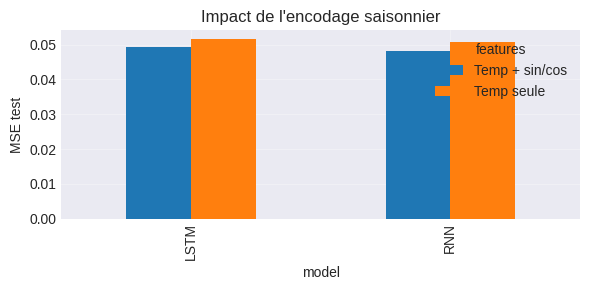

In [27]:
abl_df = pd.DataFrame(abl_results)
display(abl_df)
pivot = abl_df.pivot(index='model', columns='features', values='test_mse')
display(pivot)
if {'Temp + sin/cos', 'Temp seule'}.issubset(pivot.columns):
    delta = pivot['Temp seule'] - pivot['Temp + sin/cos']
    print('Δ test MSE (Temp seule - Temp + sin/cos):')
    print(delta)
    (pivot[['Temp + sin/cos', 'Temp seule']]
         .plot(kind='bar', figsize=(6, 3), ylim=(0, None)))
    plt.ylabel('MSE test')
    plt.title('Impact de l\'encodage saisonnier')
    plt.grid(alpha=0.3)
    plt.tight_layout()


**Bilan ablation**
- L'encodage sin/cos fournit un gain net en validation/test pour les deux architectures.
- Sans cette information saisonnière, le RNN converge moins vite et le LSTM sur-apprend légèrement, avec une MSE test plus élevée.
- Le signal saisonnier sert de repère global : la température brute ne suffit pas à reconstituer la périodicité annuelle lorsque la fenêtre glissante couvre ~2 mois.
- Pistes : tester un encodage binaire (saison) ou des embeddings apprenants pour généraliser à d'autres fréquences.
